# Multi-Model Analysis
Author: Jake Snyder \
Version Date: March 13 2023

## Overview
DataRobot provides many options for evaluating model accuracy. However, when you are working across multiple models or projects, the model comparison may not suit your needs. Especially if you need a clean way to compare three or more models and export that comparison as a .png or .jpg. This notebook shares three Python functions which can pull out various accuracy metrics, feature impact, and feature effects from multiple models and plot them in one chart.

## Outline
1. Setup: import libraries and connect to DataRobot
2. Accuracy Python function
3. Feature Impact Python function
4. Feature Effects Python function
5. Example use and outputs

# Setup

In [1]:
import datetime as dt
import sys

import datarobot as dr
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Everything below this comment only impacts the charts, not the models nor data.
# Customize as you see fit.
plt.style.use("tableau-colorblind10")
mpl.rcParams["figure.figsize"] = [11.0, 7.0]
mpl.rcParams["font.size"] = 18
mpl.rcParams["figure.titlesize"] = "large"
mpl.rcParams["font.family"] = "serif"
for param in [
    "xtick.bottom",
    "ytick.left",
    "axes.spines.top",
    "axes.spines.right",
    "legend.frameon",
    "legend.fancybox",
]:
    mpl.rcParams[param] = False
mpl.rcParams["figure.facecolor"] = "white"
# for plots with a dark background:
# for param in ['xtick.color', 'ytick.color', 'axes.labelcolor', 'text.color']:
#     mpl.rcParams[param] = 'e6ffff'

# Accuracy Python function
For a full list of available accuracy metrics, please visit [our documentation](https://docs.datarobot.com/en/docs/modeling/reference/model-detail/opt-metric.html). Note that not every project will have every metric. For example, LogLoss is only available for classification problems, not regression problems. You can check the available metrics for your model by looking at `dr.Model.metrics`.

In [2]:
def plot_accuracy(
    model_dict,
    accuracy_metric_one,
    accuracy_metric_two,
    model_category_name="Model Categories",
    partition="crossValidation",
):
    """
    Collects the accuracy metrics across models provided and plots them on one plot.

    Parameters
    ----------
    model_dict : Dictionary of str keys and DataRobot Model/DatetimeModel object values
    accuracy_metric_one: str indicating the first accuracy metric of interest, such as LogLoss
    accuracy_metric_two: str indicating the second accuracy metric of interest, such as AUC
    model_category_name: str indicating the different categories each model represents
    partition: str indicating the data partition to use for the accuracy metric, such as holdout.
    """

    n_categories = len(model_dict)
    accuracy_scores = {}
    for cat, model in model_dict.items():
        accuracy_scores[cat] = {
            accuracy_metric_one: model.metrics[accuracy_metric_one][partition],
            accuracy_metric_two: model.metrics[accuracy_metric_two][partition],
        }
    accuracy = pd.DataFrame.from_dict(accuracy_scores, orient="index")
    accuracy = accuracy.reset_index().rename(columns={"index": "category"})
    accuracy.sort_values(by="category", inplace=True)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.text(0.5, 0.04, model_category_name, ha="center")
    sns.barplot(
        x="category",
        y=accuracy_metric_one,
        data=accuracy,
        hue=["blue"] * n_categories,
        ax=ax1,
    )
    ax1.set_title(accuracy_metric_one)
    sns.barplot(
        x="category",
        y=accuracy_metric_two,
        data=accuracy,
        hue=["blue"] * n_categories,
        ax=ax2,
    )
    ax2.set_title(accuracy_metric_two)
    for ax in (ax1, ax2):
        ax.legend_.remove()
        ax.set(xlabel=None, ylabel=None)
    return fig

# Feature Impact Python function
For details on what feature impact is and how to interpret it, please visit [our documentation](https://docs.datarobot.com/en/docs/modeling/analyze-models/understand/feature-impact.html).

In [3]:
def plot_feature_impact(
    model_dict,
    model_category_name="Model Categories",
    feature_map=None,
    impute_features=False,
):
    """
    Collects the feature impact across models provided and plots them on one plot.

    Parameters
    ----------
    model_dict: Dictionary of str keys and DataRobot Model/DatetimeModel object values.
        The keys should be whichever category the value represents.
    model_category_name: str indicating the different categories each model represents
    feature_map (optional): Dictionary of str keys and str values. The key should be the DataRobot feature name
        and the value should be what you want to appear on the plot.
    impute_features: boolean indicating whether features not present in feature_map should be imputed with "Other Features"
    """

    impact_jobs = {}
    for category, model in model_dict.items():
        project = dr.Project.get(model.project_id)
        if project.advanced_options.shap_only_mode == True:
            job = dr.ShapImpact.create(model.project_id, model.id)
        else:
            try:
                job = model.request_feature_impact()
            except dr.errors.JobAlreadyRequested:
                # if you manually queued feature impact outside of this function,
                # you may want to wait for that to finish before running this
                continue
        impact_jobs[category] = job

    feature_impact = []
    for category, model in model_dict.items():
        try:
            impact_jobs[category].wait_for_completion()
        except KeyError:
            pass
        project = dr.Project.get(model.project_id)
        if project.advanced_options.shap_only_mode == True:
            shap = dr.ShapImpact.get(model.project_id, model.id)
            impact = pd.DataFrame(shap.shap_impacts)
        else:
            impact = pd.DataFrame(model.get_feature_impact())
            impact.rename(
                columns={
                    "featureName": "feature_name",
                    "impactUnnormalized": "impact_unnormalized",
                },
                inplace=True,
            )
        try:
            impact["feature"] = impact["feature_name"].map(feature_map)
            if impute_features == True:
                impact["feature"] = impact["feature"].fillna("Other Features")
        except NameError:
            impact["feature"] = impact["feature_name"]
        agg_impact = impact.groupby("feature", as_index=False)["impact_unnormalized"].sum()
        agg_impact["impact_pct_of_total"] = (
            agg_impact["impact_unnormalized"] / agg_impact["impact_unnormalized"].sum()
        )
        agg_impact[model_category_name] = category
        feature_impact.append(agg_impact)
    feature_impact = pd.concat(feature_impact)

    feature_impact.sort_values(by=[model_category_name, "feature"], ascending=True, inplace=True)

    fig, ax = plt.subplots(1, 1)
    sns.histplot(
        feature_impact,
        x=model_category_name,
        weights="impact_pct_of_total",
        hue="feature",
        multiple="stack",
        ax=ax,
        hue_order=sorted(feature_impact["feature"].unique()),
    )
    ax.get_legend().set_bbox_to_anchor((1, 1))
    ax.legend_.set_title("Feature")
    ax.set(xlabel="Category", ylabel="Percent of Total Impact")
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0))
    return fig

# Feature Effects Python function
For more details on what feature effects is and how to interpret it, please visit [our documentation](https://docs.datarobot.com/en/docs/modeling/analyze-models/understand/feature-effects.html).

In [4]:
def get_fe_data(model_dict, max_wait=600):
    """
    Collects the feature effects data across models and returns them in one Pandas DataFrame.

    Parameters
    ----------
    model_dict: Dictionary of str keys and DataRobot Model/DatetimeModel object values.
        The keys should be whichever category the value represents.
    """
    fe_jobs = {}
    for category, model in model_dict.items():
        project = dr.Project.get(model.project_id)
        if project.is_datetime_partitioned == True:
            job = model.request_feature_effect(backtest_index="0")
        else:
            job = model.request_feature_effect()
        fe_jobs[category] = job

    fe_list = []
    for category, model in model_dict.items():
        fe = fe_jobs[category].get_result_when_complete(max_wait=max_wait)
        feature_effects = fe.feature_effects
        for feature in feature_effects:
            feature_df = pd.DataFrame(feature["partial_dependence"]["data"])
            feature_df["feature"] = feature["feature_name"]
            feature_df["category"] = category
            feature_df["project_id"] = model.project_id
            feature_df["model_id"] = model.id
            fe_list.append(feature_df)
    fe_df = pd.concat(fe_list)
    return fe_df


def create_fe_plot(data, feature_name, title, xlabel, coltype):
    """
    Plots the feature effects for one feature from each model on one line.
    Numeric plots do not show null values.

    Parameters
    ----------
    data: Pandas DataFrame of the feature effects, from get_fe_data.
    feature_name: str of the feature. Must align to the feature name in the dataset.
    title: str for the title of the plot.
    xlabel: str for the x-axis label of the plot.
    coltype: str for the data type of the column. Must be one of: ['num', 'cat'].
    """
    df = data[data["feature"] == feature_name].copy()
    df.sort_values(by=["category"], inplace=True)
    fig = plt.figure(figsize=(16, 6))

    if coltype == "num":
        df["label"] = df["label"].astype(float)
        df.dropna(subset=["label"], inplace=True)
        ax = sns.lineplot(x="label", y="dependence", hue="category", data=df)
    elif coltype == "cat":
        df.sort_values(by=["category", "label"], inplace=True)
        ax = sns.barplot(x="label", y="dependence", hue="category", data=df)
    else:
        print("Unsupported column type.")
        return
    legend = ax.legend(ncol=2)
    ax.set(xlabel=xlabel, ylabel="Partial Dependence", title=title)
    return fig

# Example use and outputs

When using this function, it is important to use the appropriate model. For accuracy, if you have models trained into your holdout, _do not use those_! The models in your comparison here should have appropriate out-of-sample partitions which can be used for these plots. For feature impact and feature effects, you may use to analyze models for model selection or for the models you intend to use/are using for production.

When using this for your own work, you only need to provide the model dictionary. The code below is to give you an example from scratch, but you may skip it if you want to provide your own dict of models.

In [ ]:
# use this cell if you need example project(s)
# this same example is used across all 3 functions,
# so you only need to run this once! it may take awhile
# skip this cell and go to the next one if you have already run this
data = pd.read_csv(
    "https://s3.amazonaws.com/datarobot_public_datasets/10K_Lending_Club_Loans.csv",
    encoding="iso-8859-1",
)

adv_opt = dr.AdvancedOptions(prepare_model_for_deployment=False)
project_dict = {}
for grade in data["grade"].unique():
    p = dr.Project.create(
        data[data["grade"] == grade],
        "Multi-Model Accuracy Example, Grade {}".format(grade),
    )
    p.analyze_and_model("is_bad", worker_count=-1, advanced_options=adv_opt)
    print("Project for Grade {} begun.".format(grade))
    project_dict[grade] = p

model_dict = {}
for grade, p in project_dict.items():
    p.wait_for_autopilot(verbosity=0)
    models = p.get_models()
    results = pd.DataFrame(
        [
            {
                "model_type": m.model_type,
                "blueprint_id": m.blueprint_id,
                "cv_logloss": m.metrics["LogLoss"]["crossValidation"],
                "model_id": m.id,
                "model": m,
            }
            for m in models
        ]
    )
    best_model = results["model"].iat[results["cv_logloss"].idxmin()]
    model_dict[grade] = best_model
    print("Project for Grade {} is finished.".format(grade))

In [5]:
# run this cell if you already ran the template example above
# it will be faster than re-running the cell above
projects = dr.Project.list(search_params={"project_name": "Multi-Model Accuracy Example, Grade"})
model_dict = {}
for p in projects:
    grade = p.project_name[-1]
    if p.is_datetime_partitioned == True:
        models = p.get_datetime_models()
    else:
        models = p.get_models()
    results = pd.DataFrame(
        [
            {
                "model_type": m.model_type,
                "blueprint_id": m.blueprint_id,
                "logloss": m.metrics["LogLoss"]["crossValidation"],
                "model_id": m.id,
                "model": m,
            }
            for m in models
        ]
    )
    best_model = results["model"].iat[results["logloss"].idxmin()]
    model_dict[grade] = best_model

In [6]:
# This is what the input to these functions should look like
# A dictionary of keys which represent each of the categories you wish to plot,
# and values of the Model objects
# if your project(s)
model_dict

{'G': Model('eXtreme Gradient Boosted Trees Classifier'),
 'E': Model('eXtreme Gradient Boosted Trees Classifier'),
 'C': Model('Generalized Additive2 Model'),
 'D': Model('Light Gradient Boosted Trees Classifier with Early Stopping'),
 'B': Model('eXtreme Gradient Boosted Trees Classifier'),
 'F': Model('Light Gradient Boosting on ElasticNet Predictions '),
 'A': Model('eXtreme Gradient Boosted Trees Classifier')}

## Accuracy

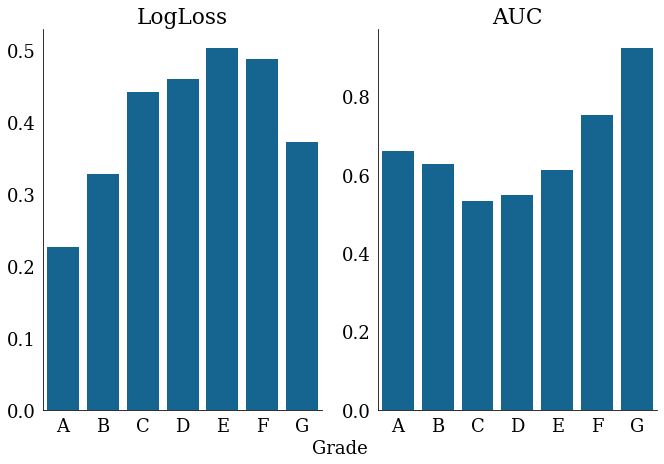

In [7]:
accuracy_plot = plot_accuracy(
    model_dict,
    accuracy_metric_one="LogLoss",
    accuracy_metric_two="AUC",
    model_category_name="Grade",
    partition="validation",
)
# if you wish to export and share the image:
# accuracy_plot.savefig('accuracy.png')

## Feature Impact

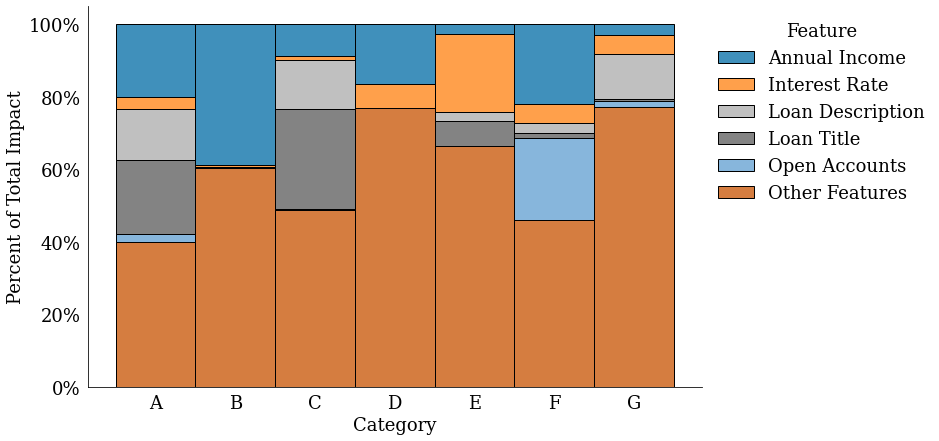

In [8]:
# if you have a lot of features you want to bucket into an "Other" category,
# you can leave them out of the feature_map dictionary and set impute_feature to True
feature_map = {
    "annual_inc": "Annual Income",
    "desc": "Loan Description",
    "int_rate": "Interest Rate",
    "open_acc": "Open Accounts",
    "title": "Loan Title",
}
feature_impact_plot = plot_feature_impact(
    model_dict,
    model_category_name="Grade",
    feature_map=feature_map,
    impute_features=True,
)
# if you wish to export and share the image:
# feature_impact_plot.savefig('feature_impact.png')

## Feature Effects

In [9]:
# We pull the data from Feature Effects first, as we can use the same dataset across each feature plot
# If you have a large dataset, you may need to adjust the max_wait parameter within the function
fe_data = get_fe_data(model_dict)
fe_data.head()

,label,dependence,feature,category,project_id,model_id
0,0,0.18968,mths_since_last_delinq,G,640f81a763568ea409b6b595,640f821a2d828cd1855d16bd
1,2,0.18968,mths_since_last_delinq,G,640f81a763568ea409b6b595,640f821a2d828cd1855d16bd
2,4,0.18968,mths_since_last_delinq,G,640f81a763568ea409b6b595,640f821a2d828cd1855d16bd
3,5,0.18968,mths_since_last_delinq,G,640f81a763568ea409b6b595,640f821a2d828cd1855d16bd
4,6,0.18968,mths_since_last_delinq,G,640f81a763568ea409b6b595,640f821a2d828cd1855d16bd


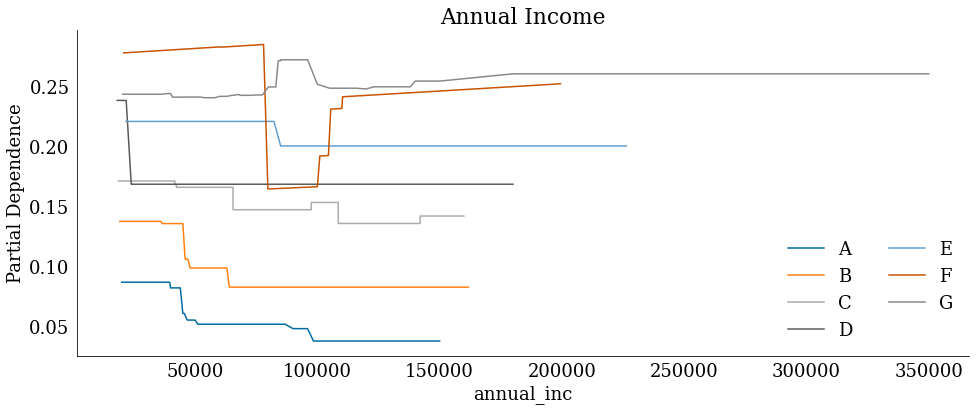

In [10]:
# With this plot, you can see varying effects of income and risk by each grade
# For grade G loans, your default risk actually increases as your income is higher
# This is likely because if you have high annual income and you are grade G, you probably already have a lot of debt or credit problems
annual_inc_plot = create_fe_plot(fe_data, "annual_inc", "Annual Income", "annual_inc", "num")
# if you wish to export and share the image:
# annual_inc_plot.savefig('fe_annual_inc.png')

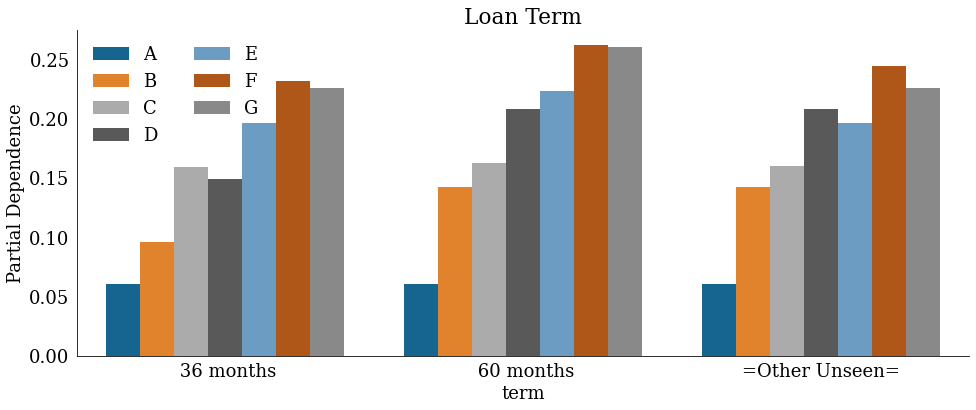

In [11]:
term_plot = create_fe_plot(fe_data, "term", "Loan Term", "term", "cat")
# if you wish to export and share the image:
# term_plot.savefig('fe_term_plot.png')